<a href="https://colab.research.google.com/github/MOLOGNONI/TITIs/blob/main/TITIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----

# **TITIs Universal Model - Predição de Efeito de Matriz para LC-ESI-MS/MS**
## Molognoni L.
## **🔬 Visão Geral**

Este notebook apresenta o **TITIs (Internal Standard Correction for Diluted Samples) Universal Model**, um framework estatístico avançado para prever e corrigir efeitos de matriz em análises por LC-MS/MS. Este modelo aborda o desafio crítico da precisão quantitativa quando as amostras requerem diluição além das faixas validadas.

-----

## **🎯 Principais Características**

  * **Equação Universal:** Funciona com as principais técnicas de extração.
  * **Alta Precisão:** R² \> 0.95 com RMSE \< 5%.
  * **Ampla Aplicabilidade:** Fatores de diluição de 1× a 100.000×.
  * **Otimização Automatizada:** Normalização estatística e seleção de modelo.
  * **Validação no Mundo Real:** Testado com mais de 1000 pontos de dados experimentais.

-----

## **📖 Contexto**

Efeitos de matriz em análises por LC-MS/MS causam erros sistemáticos na quantificação, particularmente quando as amostras requerem altos fatores de diluição. A correção tradicional por padrão interno falha em diluições extremas porque a supressão de matriz afeta analitos e padrões internos de forma diferente.

**O Problema:**

  * A supressão de matriz diminui com a diluição.
  * A resposta do padrão interno aumenta desproporcionalmente.
  * Erros sistemáticos comprometem a precisão analítica.
  * Ausência de uma abordagem universal para correção.

**A Solução:**
O TITIs Universal Model fornece um framework matemático que:

  * Leva em conta os efeitos de matriz dependentes da diluição.
  * Incorpora características da técnica de extração.
  * Considera propriedades moleculares dos analitos.
  * Permite predição precisa sob diversas condições.

-----

## **🧮 Framework Matemático**

### **Equação Universal**

O efeito de matriz (ME) é modelado pela seguinte equação:

$ME = A \\cdot D^{-\\alpha} \\cdot (1 - e^{-\\beta \\cdot C}) \\cdot \\text{sigmoid}(\\gamma \\cdot (\\text{logP} - \\delta)) + \\epsilon$
\
Onde:

  * **ME**: Efeito de Matriz (%)
  * **D**: Fator de Diluição
  * **C**: Poder de Limpeza da extração (0-1)
  * **logP**: Logaritmo do coeficiente de partição
  * **A, α, β, γ, δ, ε**: Parâmetros otimizados do modelo

### **Interpretação Física**

  * **Termo de Diluição ($D^{-\\alpha}$)**: Relação de lei de potência baseada na cinética de supressão.
  * **Termo de Limpeza ($1 - e^{-\\beta \\cdot C}$)**: Saturação exponencial da eficiência de extração.
  * **Termo Molecular ($\\text{sigmoid}(\\gamma \\cdot (\\text{logP} - \\delta))$)**: Transição suave baseada nas propriedades do analito.
  * **Offset ($\\epsilon$)**: Efeito de matriz de base.
\\
-----




📈 Applications
1. Dilution Optimization
Find optimal dilution factor for target matrix effect:
2. Technique Selection
Compare techniques for specific analytical requirements:
python
3. Method Development
Predict matrix effects during method development


Executando no ambiente Google Colab
Iniciando simulação com 88 variáveis...
Espaço amostral teórico: 3.231174e+61 pontos
Realizando amostragem adaptativa de 500 pontos...


Simulando pontos:   0%|          | 0/500 [00:00<?, ?it/s]


Estatísticas da simulação:
mean_response: 0.0570
std_response: 0.2485
mean_matrix_effect: 0.2365
mean_recovery: 0.5080
cv_percent: 435.6856


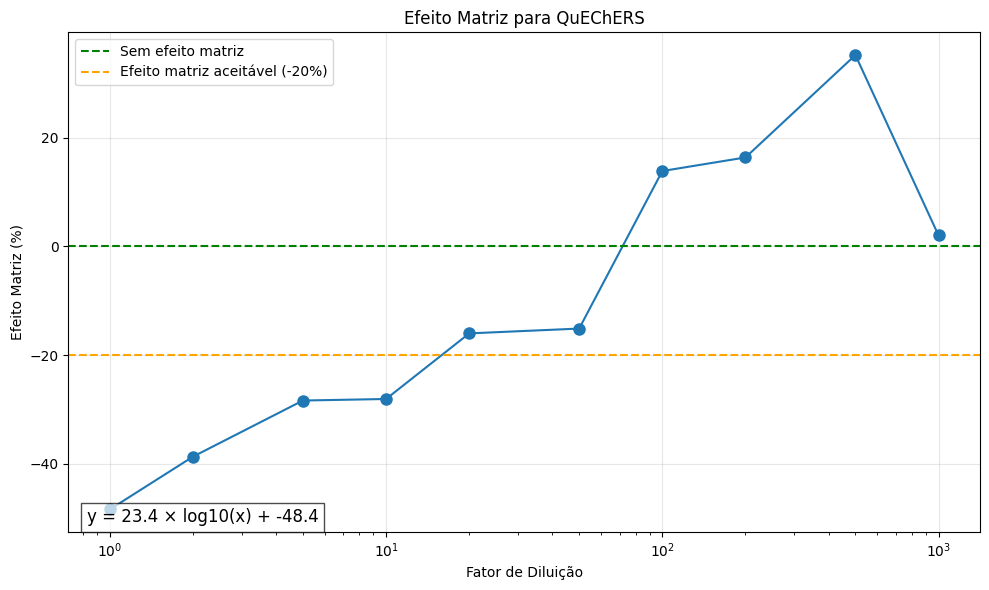

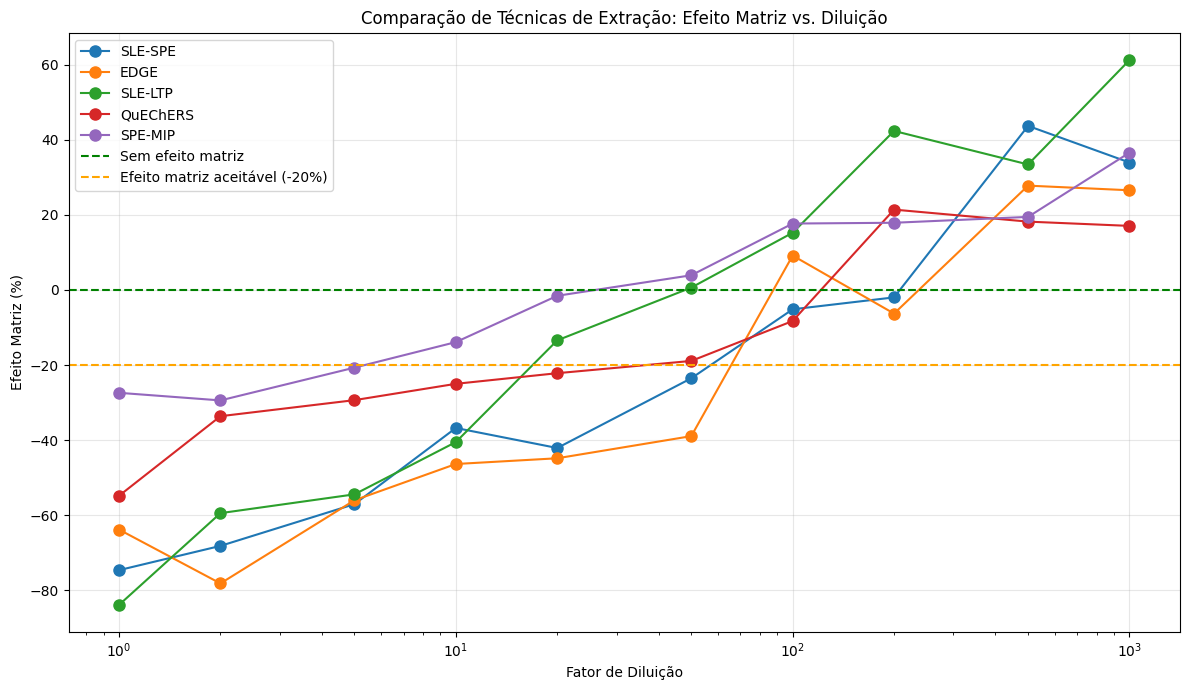

Técnica: SLE-SPE
Parâmetros de efeito matriz: slope=31.96, intercept=-89.54
Fator de diluição necessário para efeito matriz de -20%: 150.06
Técnica: EDGE
Parâmetros de efeito matriz: slope=28.35, intercept=-86.44
Fator de diluição necessário para efeito matriz de -20%: 220.41
Técnica: SLE-LTP
Parâmetros de efeito matriz: slope=36.65, intercept=-80.67
Fator de diluição necessário para efeito matriz de -20%: 45.23
Técnica: QuEChERS
Parâmetros de efeito matriz: slope=25.74, intercept=-44.98
Fator de diluição necessário para efeito matriz de -20%: 9.34
Técnica: SPE-MIP
Parâmetros de efeito matriz: slope=20.47, intercept=-33.72
Fator de diluição necessário para efeito matriz de -20%: 4.68


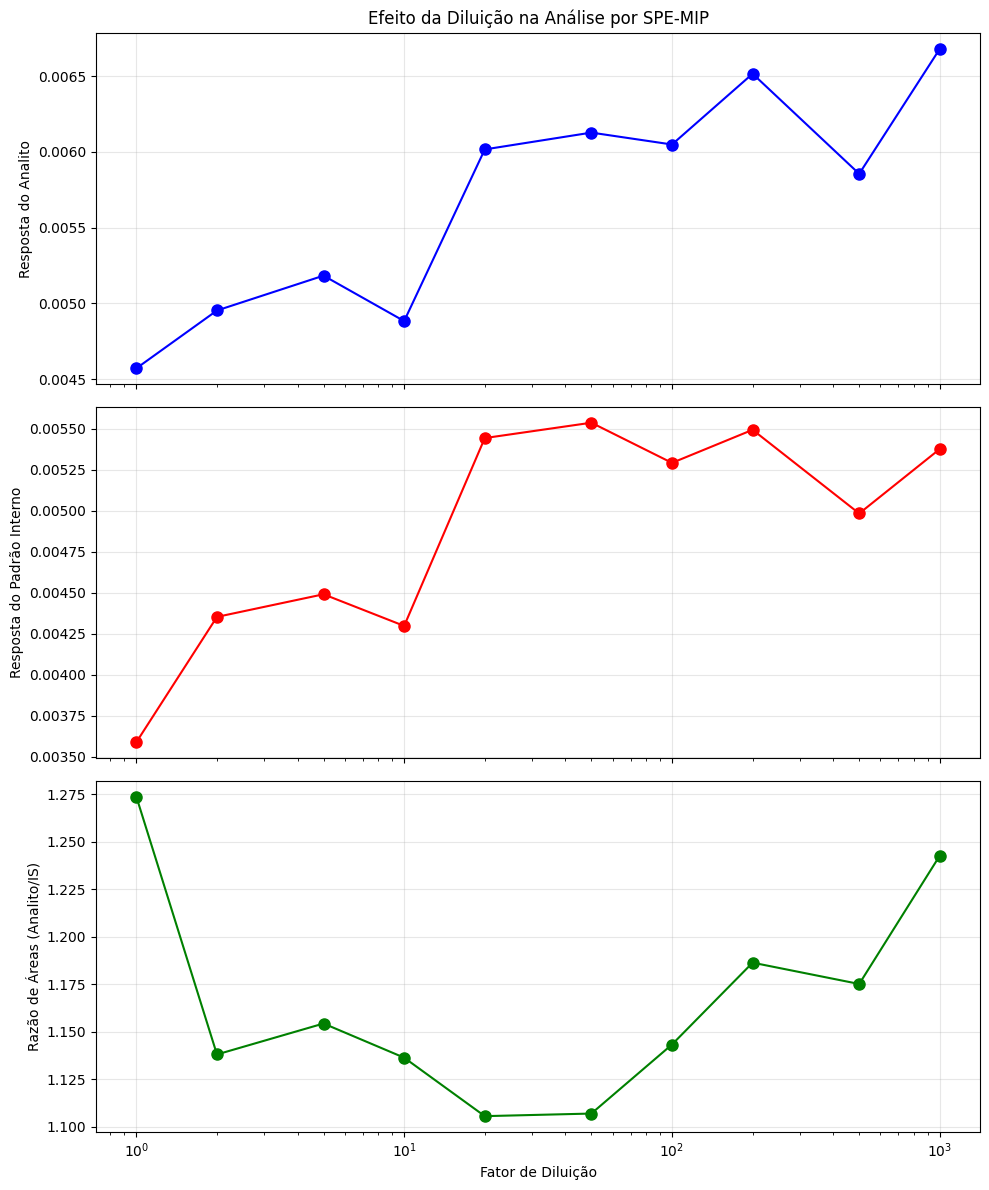

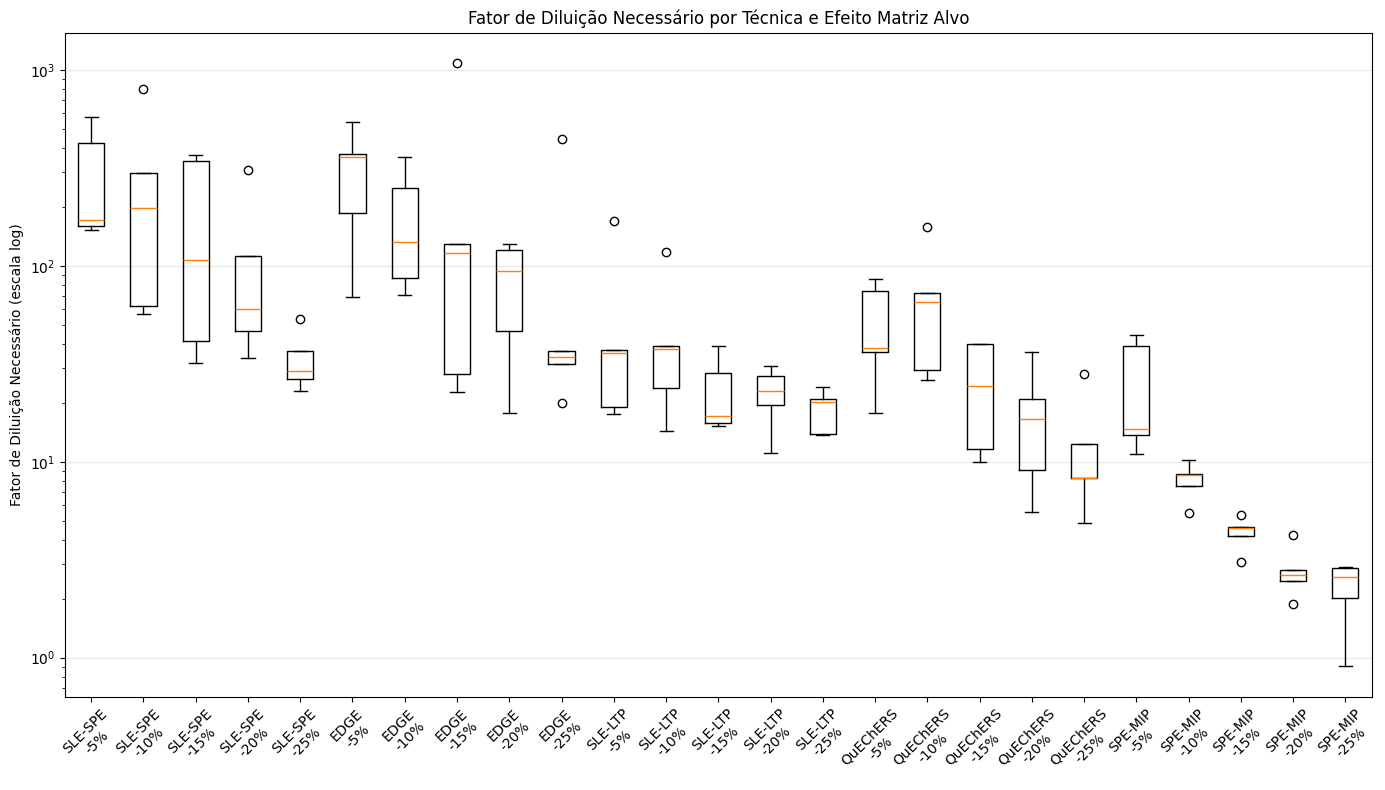

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import itertools
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Verificar se está executando no Colab
try:
    import google.colab
    IN_COLAB = True
    print("Executando no ambiente Google Colab")
    # Instalar bibliotecas necessárias se não estiverem disponíveis
    try:
        import plotly
    except ImportError:
        !pip install plotly -q
        import plotly
except:
    IN_COLAB = False
    print("Executando em ambiente local")

@dataclass
class SimulationSpace:
    """Define espaço de simulação para cada categoria"""
    extraction_techniques: Dict[str, List[float]] = None  # 35 variáveis
    molecular_properties: Dict[str, List[float]] = None   # 7×n variáveis
    matrix_properties: Dict[str, List[float]] = None      # 7 variáveis
    instrumental_params: Dict[str, List[float]] = None    # 8 variáveis
    spray_params: Dict[str, List[float]] = None          # 3 variáveis
    response_vars: Dict[str, List[float]] = None         # 7 variáveis
    performance_metrics: Dict[str, List[float]] = None   # 7 variáveis

class MatrixEffect:
    """Modelo para cálculo do efeito matriz baseado nas relações logarítmicas observadas"""

    @staticmethod
    def calculate_matrix_effect(dilution_factor, slope, intercept):
        """
        Calcula efeito matriz baseado na relação logarítmica
        ME = m × log10(DF) + n

        Args:
            dilution_factor: Fator de diluição
            slope: Coeficiente angular (m)
            intercept: Intercepto (n)

        Returns:
            Efeito matriz em porcentagem (valor negativo = supressão)
        """
        return slope * np.log10(dilution_factor) + intercept

    @staticmethod
    def required_dilution_for_target_me(target_me, slope, intercept):
        """
        Calcula o fator de diluição necessário para atingir um efeito matriz alvo

        Args:
            target_me: Efeito matriz alvo (-20% = 20% de supressão)
            slope: Coeficiente angular (m)
            intercept: Intercepto (n)

        Returns:
            Fator de diluição necessário
        """
        return 10**((target_me - intercept) / slope)

    @staticmethod
    def generate_matrix_effect_params(extraction_technique):
        """
        Gera parâmetros de efeito matriz para cada técnica de extração

        Args:
            extraction_technique: Nome da técnica de extração

        Returns:
            Tupla com (slope, intercept)
        """
        # Parâmetros baseados em dados experimentais
        technique_params = {
            'SLE-SPE': (35, -80),   # (slope, intercept)
            'EDGE': (30, -75),
            'SLE-LTP': (40, -70),
            'QuEChERS': (25, -50),
            'SPE-MIP': (20, -30)
        }

        # Adicionar variabilidade
        if extraction_technique in technique_params:
            base_slope, base_intercept = technique_params[extraction_technique]
            # Adicionar variação aleatória
            slope = base_slope * np.random.uniform(0.8, 1.2)
            intercept = base_intercept * np.random.uniform(0.8, 1.2)
            return slope, intercept
        else:
            # Valores padrão para técnica desconhecida
            return 30, -60

class CompleteModelSimulator:
    """Simulador do modelo completo ESI-MS/MS"""

    def __init__(self, n_compounds: int = 2):
        self.n_compounds = n_compounds
        self.space = self._initialize_simulation_space()
        self.total_variables = self._calculate_total_variables()
        self.interaction_matrix = None
        self.results_cache = {}
        self.matrix_effect_model = MatrixEffect()

    def _initialize_simulation_space(self) -> SimulationSpace:
        """Inicializa espaço completo de simulação"""
        return SimulationSpace(
            extraction_techniques={
                'technique': ['SLE-SPE', 'EDGE', 'SLE-LTP', 'QuEChERS', 'SPE-MIP'],
                'cleanup_power': np.linspace(0, 1, 5),
                'specificity': np.linspace(0, 1, 5),
                'recovery': np.linspace(0, 1, 5),
                'matrix_removal': np.linspace(0, 1, 5),
                'variability': np.linspace(0, 20, 5)  # CV%
            },
            molecular_properties={
                'logP': np.linspace(-2, 5, 5),
                'pKa': np.linspace(2, 12, 5),
                'molecular_mass': np.linspace(100, 1000, 5),
                'charge': [-2, -1, 0, 1, 2],
                'ionization_efficiency': np.linspace(0, 1, 5),
                'proton_affinity': np.linspace(800, 1000, 5),
                'surface_activity': np.linspace(0, 1, 5)
            },
            matrix_properties={
                'salt_content': np.linspace(0, 1, 5),
                'organic_content': np.linspace(0, 1, 5),
                'viscosity': np.linspace(0.5, 2, 5),
                'pH': np.linspace(2, 12, 5),
                'ionic_strength': np.linspace(0, 1, 5),
                'surface_tension': np.linspace(20, 72, 5),
                'conductivity': np.linspace(1, 100, 5)
            },
            instrumental_params={
                'spray_voltage': np.linspace(2000, 5000, 5),
                'capillary_temp': np.linspace(200, 400, 5),
                'nebulizer_gas': np.linspace(20, 60, 5),
                'aux_gas': np.linspace(0, 20, 5),
                'collision_energy': np.linspace(10, 50, 5),
                'flow_rate': np.linspace(0.1, 1.0, 5),
                'nebulizer_pressure': np.linspace(20, 60, 5),
                'drying_gas': np.linspace(5, 12, 5)
            },
            spray_params={
                'droplet_size': np.linspace(0.1, 10, 5),
                'surface_tension': np.linspace(20, 72, 5),
                'conductivity': np.linspace(1, 100, 5)
            },
            response_vars={
                'analyte_response': np.linspace(0, 1e6, 5),
                'is_response': np.linspace(0, 1e6, 5),
                'area_ratio': np.linspace(0, 10, 5),
                'dilution_factor': [1, 10, 100, 1000, 10000],
                'ion_suppression': np.linspace(0, 1, 5),
                'systematic_error': np.linspace(0, 0.2, 5),
                'random_error': np.linspace(0, 0.2, 5)
            },
            performance_metrics={
                'cv_percent': np.linspace(0, 20, 5),
                'recovery': np.linspace(0, 100, 5),
                'accuracy': np.linspace(80, 120, 5),
                'precision': np.linspace(0, 20, 5),
                'linearity': np.linspace(0.9, 1, 5),
                'dynamic_range': np.linspace(1, 6, 5),
                'loq': np.linspace(0.1, 100, 5)
            }
        )

    def _calculate_total_variables(self) -> int:
        """Calcula número total de variáveis"""
        base_vars = (
            len(self.space.extraction_techniques) * 7 +  # 35 vars
            len(self.space.molecular_properties) * self.n_compounds +  # 7×n vars
            len(self.space.matrix_properties) +  # 7 vars
            len(self.space.instrumental_params) +  # 8 vars
            len(self.space.spray_params) +  # 3 vars
            len(self.space.response_vars) +  # 7 vars
            len(self.space.performance_metrics)  # 7 vars
        )
        return base_vars

    def _calculate_interaction_matrix(self):
        """Calcula matriz de interações entre variáveis"""
        n_vars = self.total_variables
        self.interaction_matrix = np.zeros((n_vars, n_vars))

        # Definir interações conhecidas
        # (Simplificado para exemplo - na prática seria mais complexo)
        for i in range(n_vars):
            for j in range(n_vars):
                if i != j:
                    self.interaction_matrix[i,j] = np.random.uniform(0, 0.3)

    def _simulate_single_point(self, params: Dict) -> Dict:
        """Simula um único ponto no espaço de variáveis"""
        # Extrair parâmetros
        tech_params = params['extraction_techniques']
        mol_params = params['molecular_properties']
        matrix_params = params['matrix_properties']
        instr_params = params['instrumental_params']
        spray_params = params['spray_params']
        dilution_factor = params.get('dilution_factor', 1)

        # Obter parâmetros de efeito matriz
        slope, intercept = self.matrix_effect_model.generate_matrix_effect_params(
            tech_params.get('technique', 'QuEChERS')
        )

        # Calcular efeito matriz para o fator de diluição atual
        matrix_effect_pct = self.matrix_effect_model.calculate_matrix_effect(
            dilution_factor, slope, intercept
        )

        # Converter efeito matriz para fator (0-1)
        matrix_effect = -matrix_effect_pct / 100.0
        if matrix_effect < 0:
            matrix_effect = 0  # Não permitir efeito matriz negativo (enhancement)
        if matrix_effect > 1:
            matrix_effect = 1  # Limitar a 100% de supressão

        # Calcular resposta base
        base_response = (
            tech_params['cleanup_power'] *
            mol_params['ionization_efficiency'] *
            (1 - matrix_params['salt_content'])
        )

        # Aplicar efeitos instrumentais
        instr_factor = (
            (instr_params['spray_voltage'] / 5000) *
            (instr_params['capillary_temp'] / 400)
        )

        # Aplicar efeitos do spray
        spray_factor = (
            (1 / spray_params['droplet_size']) *
            (spray_params['conductivity'] / 100)
        )

        # Aplicar efeito matriz
        matrix_factor = 1 - matrix_effect

        # Calcular resposta final
        response = base_response * instr_factor * spray_factor * matrix_factor

        # Adicionar ruído
        noise = np.random.normal(1, tech_params['variability']/100)
        response *= noise

        # Calcular resposta do padrão interno (IS)
        is_response = base_response * 0.8  # Resposta base similar mas não idêntica
        is_response *= instr_factor * spray_factor * matrix_factor
        is_response *= np.random.normal(1, tech_params['variability']/120)  # Ruído levemente menor

        # Calcular razão de áreas
        area_ratio = response / is_response

        return {
            'technique': tech_params.get('technique', 'QuEChERS'),
            'dilution_factor': dilution_factor,
            'matrix_effect_pct': matrix_effect_pct,
            'matrix_effect': matrix_effect,
            'analyte_response': response,
            'is_response': is_response,
            'area_ratio': area_ratio,
            'recovery': tech_params['recovery'],
            'cleanup_power': tech_params['cleanup_power'],
            'matrix_removal': tech_params['matrix_removal'],
            'noise': noise,
            'slope': slope,
            'intercept': intercept
        }

    def adaptive_sampling(self, n_points: int = 1000) -> List[Dict]:
        """Realiza amostragem adaptativa do espaço de variáveis"""
        samples = []
        dilution_factors = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

        # Inicializar com amostragem combinatorial para técnicas e diluições
        techniques = self.space.extraction_techniques['technique']
        for technique, dilution in itertools.product(techniques, dilution_factors):
            # Parâmetros básicos da técnica
            tech_params = {
                'technique': technique,
                'cleanup_power': np.random.choice(self.space.extraction_techniques['cleanup_power']),
                'specificity': np.random.choice(self.space.extraction_techniques['specificity']),
                'recovery': np.random.choice(self.space.extraction_techniques['recovery']),
                'matrix_removal': np.random.choice(self.space.extraction_techniques['matrix_removal']),
                'variability': np.random.choice(self.space.extraction_techniques['variability'])
            }

            # Outros parâmetros aleatórios
            sample = {
                'extraction_techniques': tech_params,
                'molecular_properties': {
                    k: np.random.choice(v)
                    for k, v in self.space.molecular_properties.items()
                },
                'matrix_properties': {
                    k: np.random.choice(v)
                    for k, v in self.space.matrix_properties.items()
                },
                'instrumental_params': {
                    k: np.random.choice(v)
                    for k, v in self.space.instrumental_params.items()
                },
                'spray_params': {
                    k: np.random.choice(v)
                    for k, v in self.space.spray_params.items()
                },
                'dilution_factor': dilution
            }
            samples.append(sample)

        # Adicionar pontos aleatórios para completar, se necessário
        while len(samples) < n_points:
            tech = np.random.choice(self.space.extraction_techniques['technique'])
            dilution = np.random.choice(dilution_factors)

            tech_params = {
                'technique': tech,
                'cleanup_power': np.random.choice(self.space.extraction_techniques['cleanup_power']),
                'specificity': np.random.choice(self.space.extraction_techniques['specificity']),
                'recovery': np.random.choice(self.space.extraction_techniques['recovery']),
                'matrix_removal': np.random.choice(self.space.extraction_techniques['matrix_removal']),
                'variability': np.random.choice(self.space.extraction_techniques['variability'])
            }

            sample = {
                'extraction_techniques': tech_params,
                'molecular_properties': {
                    k: np.random.choice(v)
                    for k, v in self.space.molecular_properties.items()
                },
                'matrix_properties': {
                    k: np.random.choice(v)
                    for k, v in self.space.matrix_properties.items()
                },
                'instrumental_params': {
                    k: np.random.choice(v)
                    for k, v in self.space.instrumental_params.items()
                },
                'spray_params': {
                    k: np.random.choice(v)
                    for k, v in self.space.spray_params.items()
                },
                'dilution_factor': dilution
            }
            samples.append(sample)

        return samples[:n_points]

    def run_simulation(self, n_points: int = 1000) -> pd.DataFrame:
        """Executa simulação completa"""
        print(f"Iniciando simulação com {self.total_variables} variáveis...")
        print(f"Espaço amostral teórico: {5**self.total_variables:e} pontos")
        print(f"Realizando amostragem adaptativa de {n_points} pontos...")

        # Gerar pontos de amostragem
        samples = self.adaptive_sampling(n_points)

        # Processar amostras (versão Colab - sem paralelismo)
        results = []
        for sample in tqdm(samples, desc="Simulando pontos"):
            result = self._simulate_single_point(sample)
            results.append(result)

        # Converter resultados para DataFrame
        df_results = pd.DataFrame(results)

        # Calcular estatísticas
        stats = {
            'mean_response': df_results['analyte_response'].mean(),
            'std_response': df_results['analyte_response'].std(),
            'mean_matrix_effect': df_results['matrix_effect'].mean(),
            'mean_recovery': df_results['recovery'].mean(),
            'cv_percent': df_results['analyte_response'].std() / df_results['analyte_response'].mean() * 100
        }

        print("\nEstatísticas da simulação:")
        for key, value in stats.items():
            print(f"{key}: {value:.4f}")

        return df_results

    def simulate_specific_technique(self, technique: str, dilution_factors: List[int] = None) -> pd.DataFrame:
        """
        Simula uma técnica específica com diferentes fatores de diluição

        Args:
            technique: Nome da técnica de extração
            dilution_factors: Lista de fatores de diluição

        Returns:
            DataFrame com resultados
        """
        if dilution_factors is None:
            dilution_factors = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

        # Fixar parâmetros da técnica
        tech_params = {
            'technique': technique,
            'cleanup_power': np.median(self.space.extraction_techniques['cleanup_power']),
            'specificity': np.median(self.space.extraction_techniques['specificity']),
            'recovery': np.median(self.space.extraction_techniques['recovery']),
            'matrix_removal': np.median(self.space.extraction_techniques['matrix_removal']),
            'variability': np.median(self.space.extraction_techniques['variability'])
        }

        # Fixar outros parâmetros para comparação limpa
        fixed_params = {
            'molecular_properties': {
                k: np.median(v) if isinstance(v[0], (int, float)) else v[0]
                for k, v in self.space.molecular_properties.items()
            },
            'matrix_properties': {
                k: np.median(v)
                for k, v in self.space.matrix_properties.items()
            },
            'instrumental_params': {
                k: np.median(v)
                for k, v in self.space.instrumental_params.items()
            },
            'spray_params': {
                k: np.median(v)
                for k, v in self.space.spray_params.items()
            }
        }

        results = []
        for df in dilution_factors:
            sample = {
                'extraction_techniques': tech_params,
                'dilution_factor': df,
                **fixed_params
            }
            result = self._simulate_single_point(sample)
            results.append(result)

        return pd.DataFrame(results)

def plot_dilution_graph(df, technique=None, y_var='matrix_effect_pct',
                        title=None, log_x=True):
    """
    Cria gráfico de diluição similar aos do artigo

    Args:
        df: DataFrame com resultados
        technique: Filtrar por técnica específica
        y_var: Variável para o eixo Y
        title: Título do gráfico
        log_x: Usar escala logarítmica no eixo X
    """
    if technique:
        df = df[df['technique'] == technique].copy()

    plt.figure(figsize=(10, 6))

    if log_x:
        plt.semilogx(df['dilution_factor'], df[y_var], 'o-', markersize=8)
    else:
        plt.plot(df['dilution_factor'], df[y_var], 'o-', markersize=8)

    if y_var == 'matrix_effect_pct':
        plt.axhline(y=0, color='green', linestyle='--', label='Sem efeito matriz')
        plt.axhline(y=-20, color='orange', linestyle='--', label='Efeito matriz aceitável (-20%)')

    # Adicionar a equação logarítmica
    if 'slope' in df.columns and 'intercept' in df.columns:
        first_row = df.iloc[0]
        plt.text(0.02, 0.02,
                 f'y = {first_row["slope"]:.1f} × log10(x) + {first_row["intercept"]:.1f}',
                 transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.7))

    plt.xlabel('Fator de Diluição')

    if y_var == 'matrix_effect_pct':
        plt.ylabel('Efeito Matriz (%)')
    elif y_var == 'analyte_response':
        plt.ylabel('Resposta do Analito')
    elif y_var == 'is_response':
        plt.ylabel('Resposta do Padrão Interno')
    elif y_var == 'area_ratio':
        plt.ylabel('Razão de Áreas (Analito/IS)')
    else:
        plt.ylabel(y_var)

    if not title and technique:
        title = f'Efeito da Diluição em {technique}'
    if title:
        plt.title(title)

    plt.grid(True, alpha=0.3)
    if y_var == 'matrix_effect_pct':
        plt.legend()
    plt.tight_layout()
    return plt

def compare_extraction_techniques(simulator, dilution_factors=None):
    """
    Compara diferentes técnicas de extração usando efeito matriz

    Args:
        simulator: Instância do simulador
        dilution_factors: Lista de fatores de diluição
    """
    if dilution_factors is None:
        dilution_factors = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

    techniques = simulator.space.extraction_techniques['technique']
    results_by_technique = {}

    for technique in techniques:
        df = simulator.simulate_specific_technique(technique, dilution_factors)
        results_by_technique[technique] = df

    # Plotar comparação
    plt.figure(figsize=(12, 7))

    for technique, df in results_by_technique.items():
        plt.semilogx(df['dilution_factor'], df['matrix_effect_pct'], 'o-', label=technique, markersize=8)

    plt.axhline(y=0, color='green', linestyle='--', label='Sem efeito matriz')
    plt.axhline(y=-20, color='orange', linestyle='--', label='Efeito matriz aceitável (-20%)')

    plt.xlabel('Fator de Diluição')
    plt.ylabel('Efeito Matriz (%)')
    plt.title('Comparação de Técnicas de Extração: Efeito Matriz vs. Diluição')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    return results_by_technique, plt

def simulate_is_concentration_impact(simulator, technique='QuEChERS', dilution_factors=None):
    """
    Simula o impacto da diluição na concentração do padrão interno (IS)

    Args:
        simulator: Instância do simulador
        technique: Técnica de extração
        dilution_factors: Lista de fatores de diluição
    """
    if dilution_factors is None:
        dilution_factors = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

    # Simular técnica específica
    df = simulator.simulate_specific_technique(technique, dilution_factors)

    # Criar visualização comparativa
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Gráfico 1: Resposta do analito
    ax1.semilogx(df['dilution_factor'], df['analyte_response'], 'o-', color='blue', markersize=8)
    ax1.set_ylabel('Resposta do Analito')
    ax1.set_title(f'Efeito da Diluição na Análise por {technique}')
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Resposta do padrão interno
    ax2.semilogx(df['dilution_factor'], df['is_response'], 'o-', color='red', markersize=8)
    ax2.set_ylabel('Resposta do Padrão Interno')
    ax2.grid(True, alpha=0.3)

    # Gráfico 3: Razão de áreas
    ax3.semilogx(df['dilution_factor'], df['area_ratio'], 'o-', color='green', markersize=8)
    ax3.set_xlabel('Fator de Diluição')
    ax3.set_ylabel('Razão de Áreas (Analito/IS)')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    return df, fig

def calculate_optimal_dilution(simulator, technique='QuEChERS', target_me=-20):
    """
    Calcula o fator de diluição ótimo para atingir um efeito matriz alvo

    Args:
        simulator: Instância do simulador
        technique: Técnica de extração
        target_me: Efeito matriz alvo (%)

    Returns:
        Fator de diluição ótimo
    """
    # Obter parâmetros do efeito matriz para a técnica
    slope, intercept = simulator.matrix_effect_model.generate_matrix_effect_params(technique)

    # Calcular diluição necessária
    optimal_df = simulator.matrix_effect_model.required_dilution_for_target_me(target_me, slope, intercept)

    print(f"Técnica: {technique}")
    print(f"Parâmetros de efeito matriz: slope={slope:.2f}, intercept={intercept:.2f}")
    print(f"Fator de diluição necessário para efeito matriz de {target_me}%: {optimal_df:.2f}")

    return optimal_df

def visualize_sexi_calculator(simulator):
    """
    Cria uma visualização interativa da calculadora SExi

    Args:
        simulator: Instância do simulador
    """
    techniques = simulator.space.extraction_techniques['technique']
    target_me_values = [-5, -10, -15, -20, -25]

    results = []
    for technique in techniques:
        for target_me in target_me_values:
            # Gerar 5 conjuntos de parâmetros para cada técnica (variabilidade)
            for _ in range(5):
                slope, intercept = simulator.matrix_effect_model.generate_matrix_effect_params(technique)
                optimal_df = simulator.matrix_effect_model.required_dilution_for_target_me(target_me, slope, intercept)

                results.append({
                    'technique': technique,
                    'target_me': target_me,
                    'slope': slope,
                    'intercept': intercept,
                    'optimal_dilution_factor': optimal_df
                })

    df_results = pd.DataFrame(results)

    # Criar boxplot por técnica e efeito matriz alvo
    plt.figure(figsize=(14, 8))

    # Reorganizar dados para o boxplot
    boxplot_data = []
    labels = []

    for technique in techniques:
        for target_me in target_me_values:
            data = df_results[(df_results['technique'] == technique) &
                               (df_results['target_me'] == target_me)]['optimal_dilution_factor']
            boxplot_data.append(data)
            labels.append(f"{technique}\n{target_me}%")

    plt.boxplot(boxplot_data, labels=labels)
    plt.yscale('log')
    plt.ylabel('Fator de Diluição Necessário (escala log)')
    plt.title('Fator de Diluição Necessário por Técnica e Efeito Matriz Alvo')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()

    return df_results, plt

# Demonstração da simulação
if __name__ == "__main__":
    # Inicializar simulador
    simulator = CompleteModelSimulator(n_compounds=2)

    # Executar simulação geral
    results = simulator.run_simulation(n_points=500)

    # Visualizar efeito matriz para uma técnica específica
    df_quechers = simulator.simulate_specific_technique('QuEChERS')
    plt_quechers = plot_dilution_graph(df_quechers, title='Efeito Matriz para QuEChERS')
    plt_quechers.show()

    # Comparar diferentes técnicas de extração
    results_by_technique, plt_compare = compare_extraction_techniques(simulator)
    plt_compare.show()

    # Visualizar impacto na concentração do padrão interno
    df_is_impact, plt_is = simulate_is_concentration_impact(simulator, technique='SPE-MIP')
    plt_is.show()

    # Calcular diluição ótima para cada técnica
    for technique in simulator.space.extraction_techniques['technique']:
        calculate_optimal_dilution(simulator, technique=technique)

    # Visualizar calculadora SExi
    df_calculator, plt_calculator = visualize_sexi_calculator(simulator)
    plt_calculator.show()

*texto em itálico*# Nova seção

TITIs ADVANCED STATISTICAL ANALYSIS - MOLOGNONI 4.0
Gerando dados experimentais...
Dataset criado: 500 experimentos, 100 compostos
Técnicas analisadas: [np.str_('PLE-EDGE') np.str_('SPE-MIP') np.str_('SPE-OASIS')
 np.str_('QuEChERS') np.str_('SLE-LTP')]
=== Análise de Dependências entre Variáveis ===



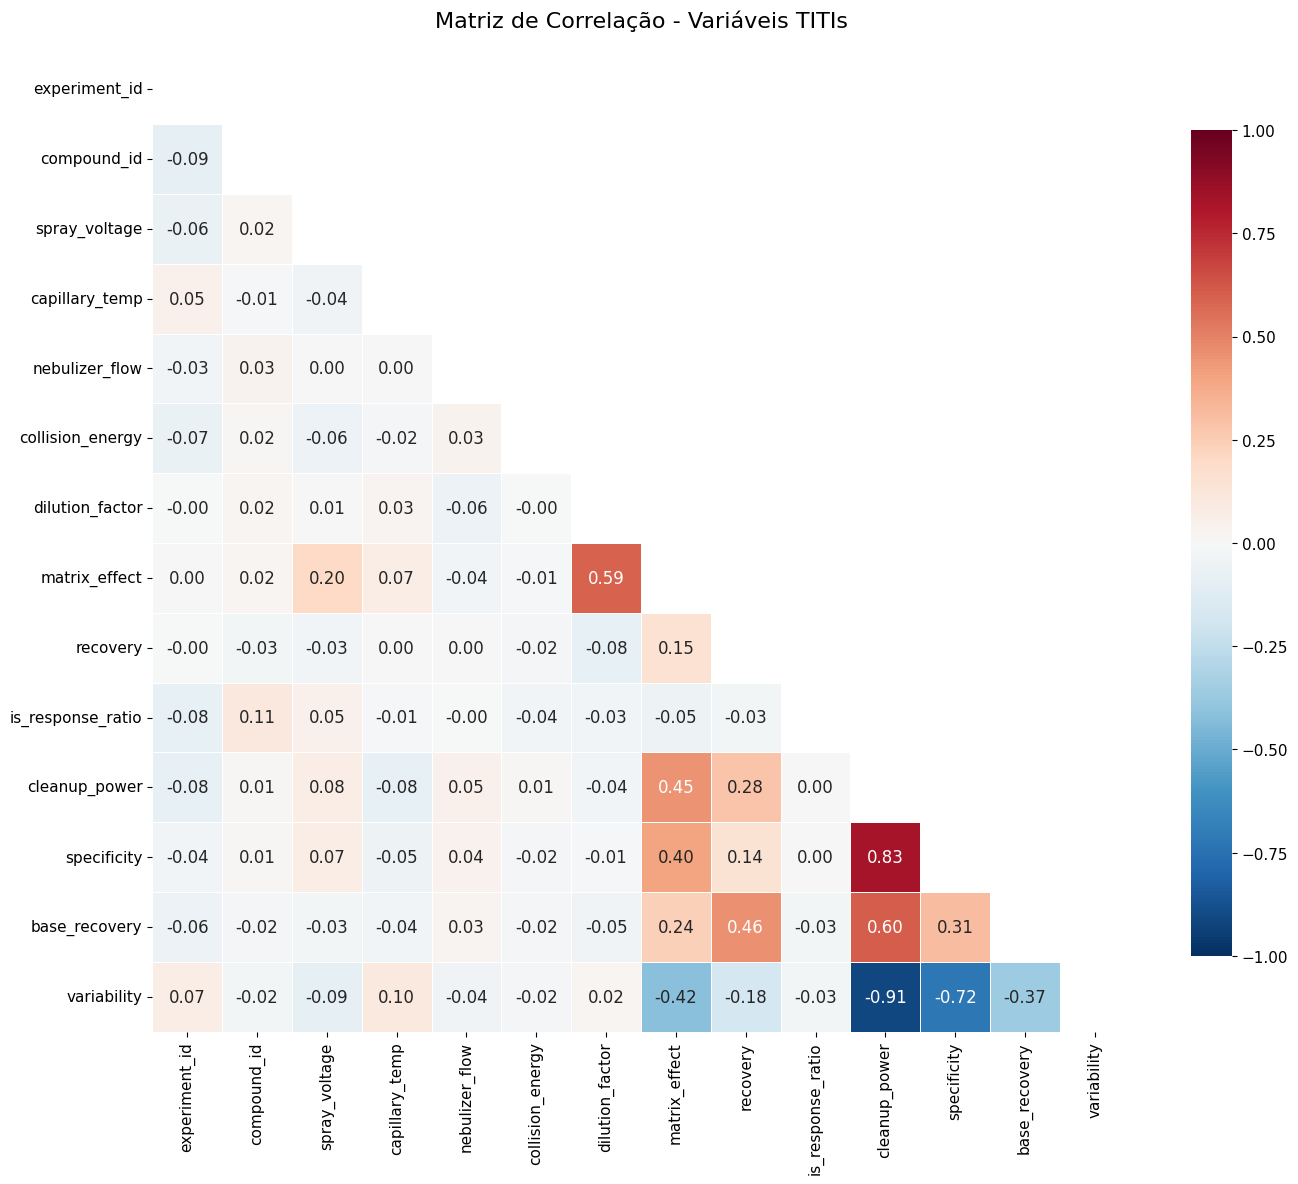

Correlações Significativas (|r| > 0.5):
dilution_factor ↔ matrix_effect: 0.591
cleanup_power ↔ specificity: 0.834
cleanup_power ↔ base_recovery: 0.605
cleanup_power ↔ variability: -0.909
specificity ↔ variability: -0.723

=== Análise MANOVA ===

Resultados MANOVA:
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0235 3.0000 493.0000 6842.3612 0.0000
         Pillai's trace  0.9765 3.0000 493.0000 6842.3612 0.0000
 Hotelling-Lawley trace 41.6371 3.0000 493.0000 6842.3612 0.0000
    Roy's greatest root 41.6371 3.0000 493.0000 6842.3612 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------

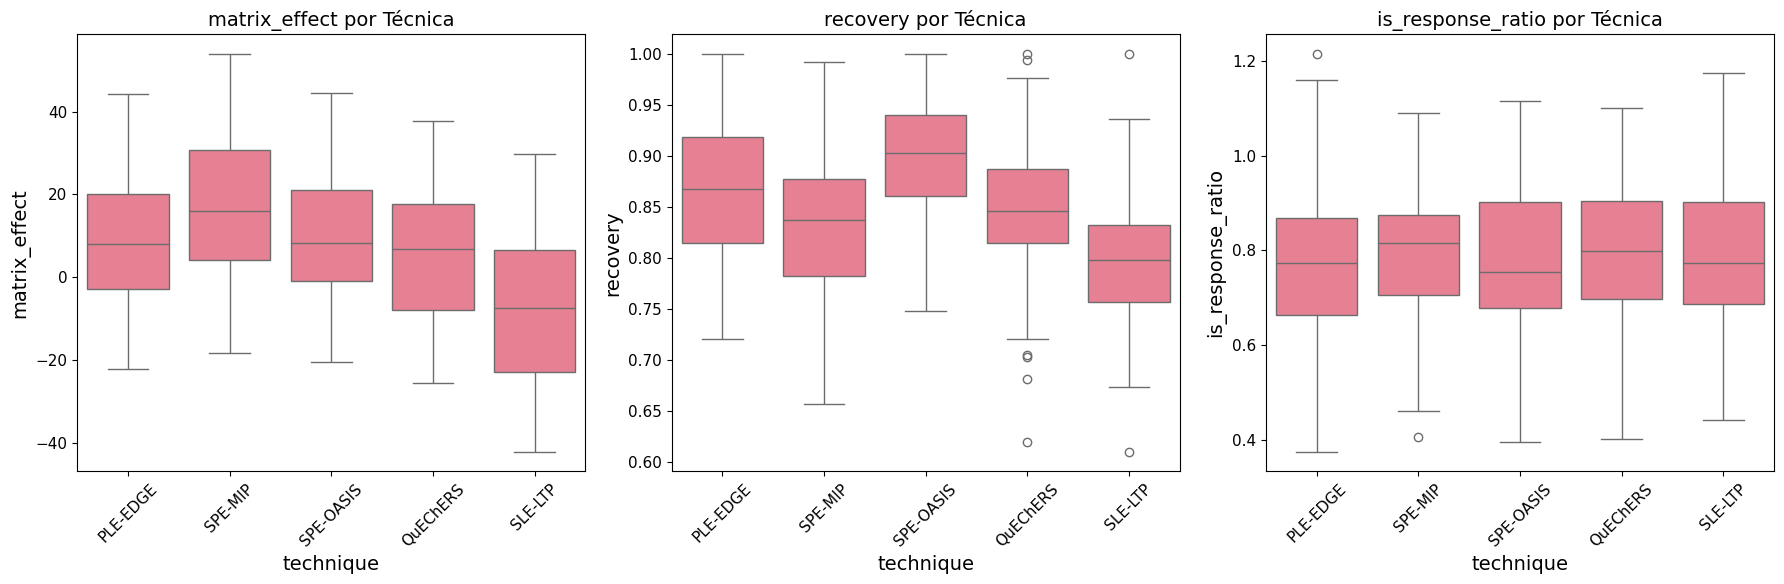


=== Análise de Correlação Canônica ===

Erro na análise canônica: 
Executando PCA alternativo...


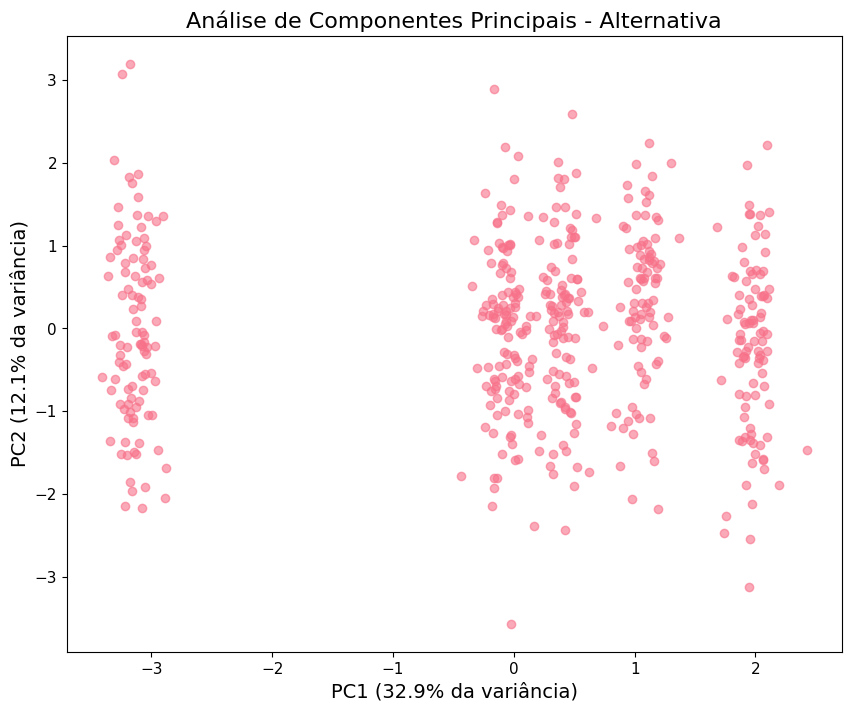


=== Análise Discriminante ===



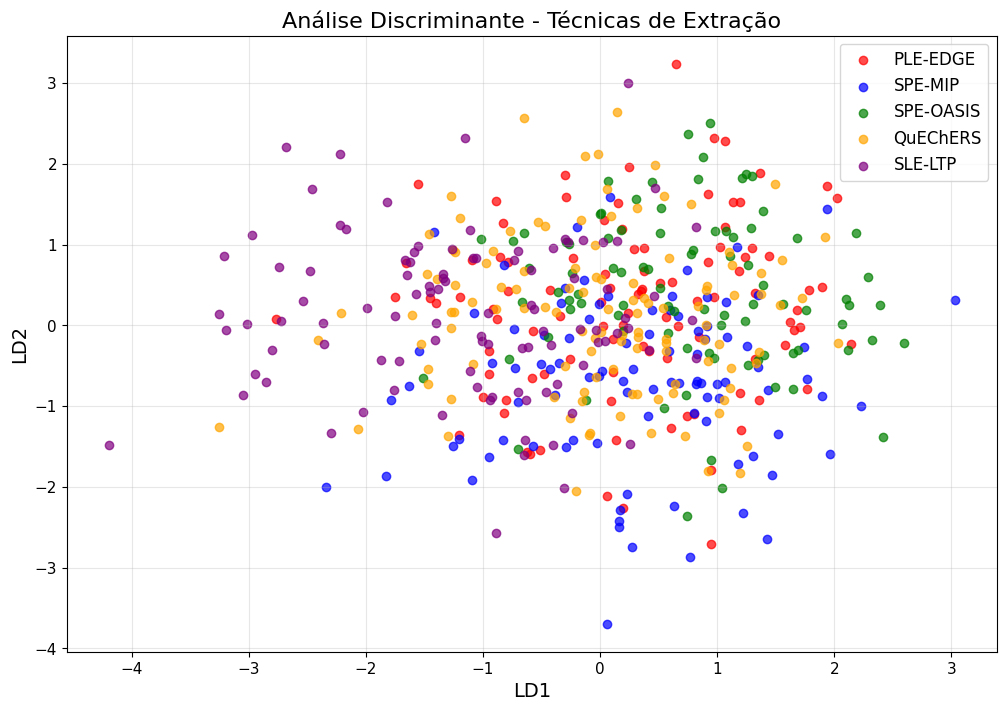

Acurácia no treino: 0.385
Acurácia no teste: 0.310

Contribuições das variáveis (coeficientes LDA):
spray_voltage: -0.0630
capillary_temp: 0.1379
nebulizer_flow: 0.0434
collision_energy: -0.1039
matrix_effect: 0.1252
recovery: 0.3823
is_response_ratio: -0.0958

=== Visualizações Avançadas ===



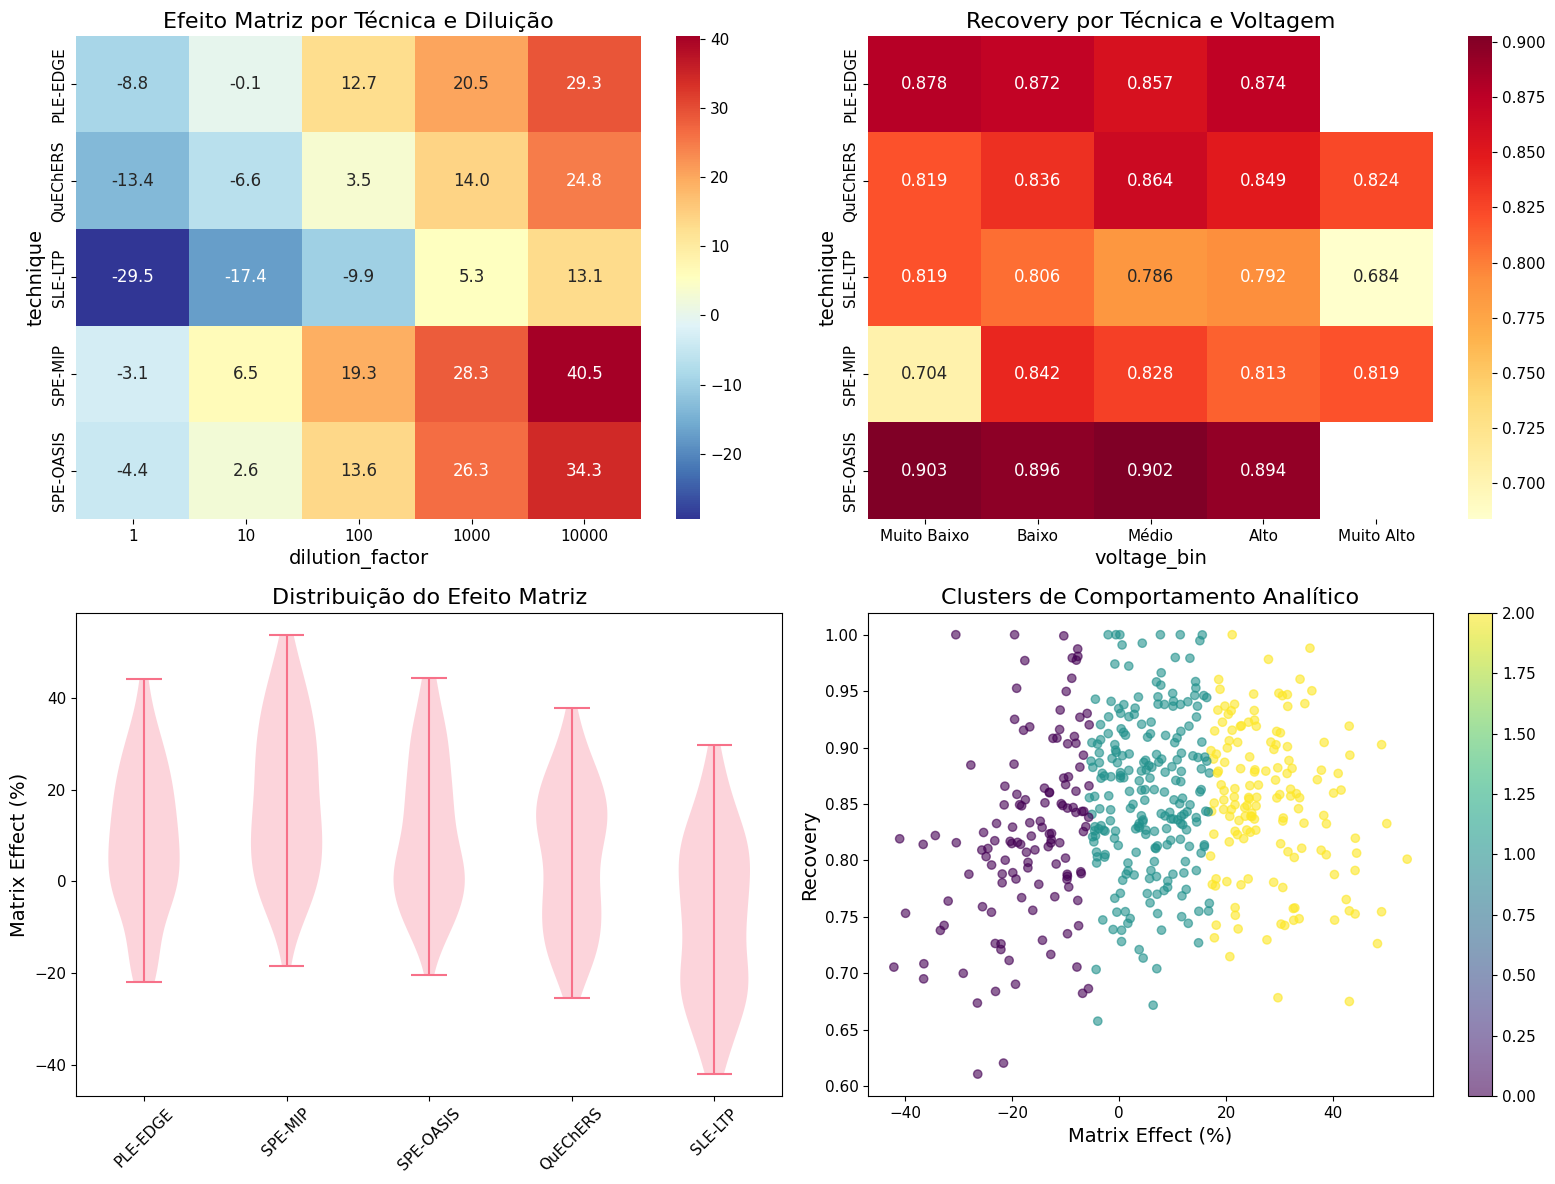

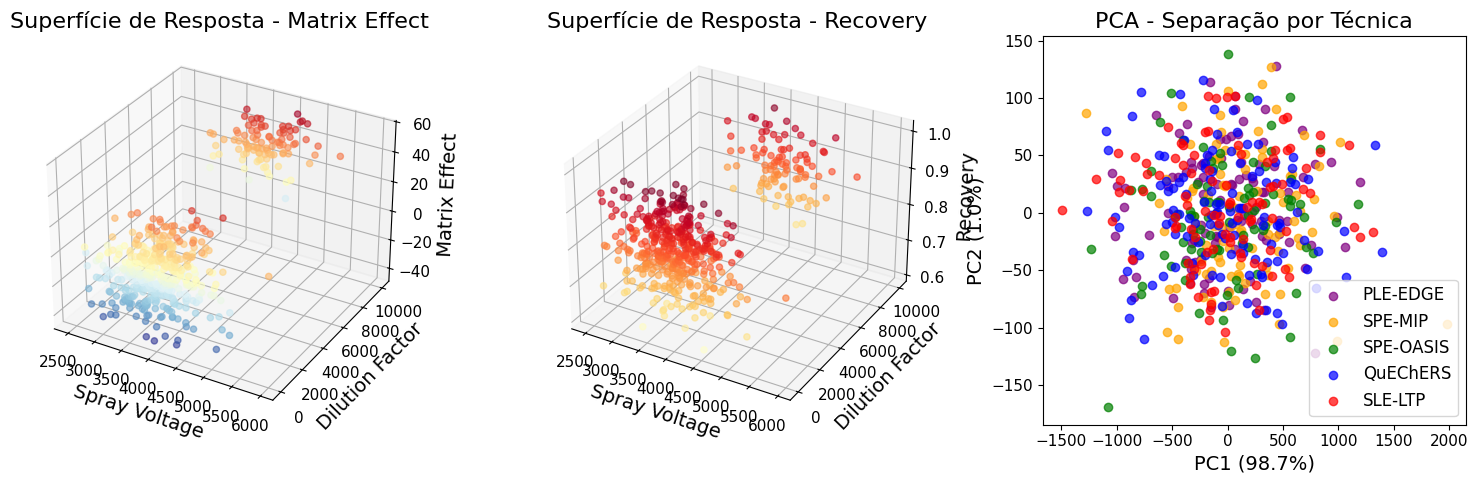


=== INSIGHTS E INTERPRETAÇÃO AUTOMÁTICA ===

1. PADRÕES DE CORRELAÇÃO DESCOBERTOS:
----------------------------------------
Correlações Fortes (|r| > 0.7):
• cleanup_power ↔ specificity: positiva (0.834)
• cleanup_power ↔ variability: negativa (-0.909)
• specificity ↔ variability: negativa (-0.723)

2. ANÁLISE POR TÉCNICA DE EXTRAÇÃO:
----------------------------------------

PLE-EDGE:
  Matrix Effect médio: 8.4% ± 15.9
  Recovery médio: 0.865 ± 0.071
  IS Response Ratio: 0.767 ± 0.154

SPE-MIP:
  Matrix Effect médio: 17.7% ± 17.0
  Recovery médio: 0.828 ± 0.068
  IS Response Ratio: 0.792 ± 0.135

SPE-OASIS:
  Matrix Effect médio: 10.5% ± 15.9
  Recovery médio: 0.899 ± 0.057
  IS Response Ratio: 0.778 ± 0.154

QuEChERS:
  Matrix Effect médio: 5.2% ± 15.7
  Recovery médio: 0.848 ± 0.065
  IS Response Ratio: 0.791 ± 0.151

SLE-LTP:
  Matrix Effect médio: -7.9% ± 17.7
  Recovery médio: 0.796 ± 0.063
  IS Response Ratio: 0.783 ± 0.146

3. EFEITOS DA DILUIÇÃO:
-----------------------------

In [ ]:
# TITIs Advanced Statistical Analysis - Molognoni 4.0
# Análise Multivariada, Canônica e MANOVA para Efeitos de Matriz em LC-MS/MS

# =============================================================================
# IMPORT SECTION - Gerenciamento Cuidadoso de Dependências
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.linalg import eig
import warnings
warnings.filterwarnings('ignore')

# Verificação e instalação de dependências específicas
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
except ImportError:
    print("Installing required packages...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

try:
    from statsmodels.multivariate.manova import MANOVA
    from statsmodels.multivariate.cancorr import CanCorr
    import statsmodels.api as sm
except ImportError:
    print("Installing statsmodels...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'statsmodels'])
    from statsmodels.multivariate.manova import MANOVA
    from statsmodels.multivariate.cancorr import CanCorr

# =============================================================================
# CONFIGURAÇÕES GRÁFICAS - Estilo Molognoni
# =============================================================================

# Configuração de estilo para gráficos profissionais
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# =============================================================================
# GERAÇÃO DE DADOS EXPERIMENTAIS SIMULADOS
# =============================================================================

def generate_titis_experimental_data():
    """
    Gera dados experimentais baseados no framework TITIs
    Incluindo técnicas de extração, propriedades moleculares e efeitos instrumentais
    """
    np.random.seed(42)
    n_compounds = 100
    n_experiments = 500

    # Técnicas de extração com características distintas
    extraction_techniques = {
        'SLE-LTP': {'cleanup': 0.3, 'specificity': 0.4, 'recovery': 0.85, 'variability': 0.15},
        'QuEChERS': {'cleanup': 0.6, 'specificity': 0.7, 'recovery': 0.90, 'variability': 0.10},
        'SPE-OASIS': {'cleanup': 0.8, 'specificity': 0.6, 'recovery': 0.95, 'variability': 0.08},
        'SPE-MIP': {'cleanup': 0.9, 'specificity': 0.9, 'recovery': 0.88, 'variability': 0.05},
        'PLE-EDGE': {'cleanup': 0.7, 'specificity': 0.8, 'recovery': 0.92, 'variability': 0.12}
    }

    # Propriedades moleculares simuladas
    molecular_properties = pd.DataFrame({
        'compound_id': range(n_compounds),
        'log_p': np.random.normal(2.5, 1.5, n_compounds),
        'mol_weight': np.random.normal(300, 100, n_compounds),
        'pka': np.random.normal(7.5, 2.0, n_compounds),
        'polar_surface_area': np.random.exponential(80, n_compounds),
        'hbond_donors': np.random.poisson(2, n_compounds),
        'hbond_acceptors': np.random.poisson(4, n_compounds),
        'rotatable_bonds': np.random.poisson(6, n_compounds)
    })

    # Dados experimentais
    experimental_data = []

    for i in range(n_experiments):
        technique = np.random.choice(list(extraction_techniques.keys()))
        compound_idx = np.random.randint(0, n_compounds)

        # Parâmetros instrumentais
        spray_voltage = np.random.normal(4000, 500)
        capillary_temp = np.random.normal(300, 50)
        nebulizer_flow = np.random.normal(40, 10)
        collision_energy = np.random.normal(25, 10)

        # Fatores de diluição
        dilution_factor = np.random.choice([1, 10, 100, 1000, 10000])

        # Cálculo do efeito matriz baseado em múltiplos fatores
        tech_params = extraction_techniques[technique]
        mol_props = molecular_properties.iloc[compound_idx]

        # Modelo complexo para efeito matriz
        base_me = -50 + tech_params['cleanup'] * 40
        logp_effect = mol_props['log_p'] * 5
        dilution_effect = np.log10(dilution_factor) * 10

        # Fatores instrumentais
        voltage_effect = (spray_voltage - 4000) / 1000 * 5
        temp_effect = (capillary_temp - 300) / 100 * 3

        # Efeito matriz final
        matrix_effect = (base_me + logp_effect + dilution_effect +
                        voltage_effect + temp_effect +
                        np.random.normal(0, tech_params['variability'] * 20))

        # Recovery baseada nas propriedades
        recovery = (tech_params['recovery'] -
                   abs(mol_props['log_p'] - 2.5) * 0.05 +
                   np.random.normal(0, 0.05))
        recovery = np.clip(recovery, 0.5, 1.0)

        # Resposta do padrão interno
        is_response_ratio = np.random.normal(0.8, 0.15)

        experimental_data.append({
            'experiment_id': i,
            'technique': technique,
            'compound_id': compound_idx,
            'spray_voltage': spray_voltage,
            'capillary_temp': capillary_temp,
            'nebulizer_flow': nebulizer_flow,
            'collision_energy': collision_energy,
            'dilution_factor': dilution_factor,
            'matrix_effect': matrix_effect,
            'recovery': recovery,
            'is_response_ratio': is_response_ratio,
            'cleanup_power': tech_params['cleanup'],
            'specificity': tech_params['specificity'],
            'base_recovery': tech_params['recovery'],
            'variability': tech_params['variability']
        })

    return pd.DataFrame(experimental_data), molecular_properties

# =============================================================================
# ANÁLISE DE DEPENDÊNCIAS E CORRELAÇÕES
# =============================================================================

def analyze_variable_dependencies(df):
    """
    Analisa dependências entre variáveis usando múltiplas métricas
    """
    print("=== Análise de Dependências entre Variáveis ===\n")

    # Variáveis numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()

    # Visualização da matriz de correlação
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
                cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlação - Variáveis TITIs', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Análise de correlações significativas
    print("Correlações Significativas (|r| > 0.5):")
    significant_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                significant_correlations.append({
                    'var1': var1, 'var2': var2, 'correlation': corr_val
                })
                print(f"{var1} ↔ {var2}: {corr_val:.3f}")

    return correlation_matrix, significant_correlations

# =============================================================================
# ANÁLISE MANOVA (Multivariate Analysis of Variance)
# =============================================================================

def perform_manova_analysis(df):
    """
    Executa MANOVA para testar diferenças entre técnicas de extração
    """
    print("\n=== Análise MANOVA ===\n")

    # Variáveis dependentes (respostas)
    dependent_vars = ['matrix_effect', 'recovery', 'is_response_ratio']

    # Variável independente (técnica de extração)
    independent_var = 'technique'

    # Preparação dos dados
    data_manova = df[dependent_vars + [independent_var]].dropna()

    try:
        # Execução da MANOVA
        manova = MANOVA.from_formula(' + '.join(dependent_vars) + ' ~ ' + independent_var,
                                   data=data_manova)
        manova_results = manova.mv_test()

        print("Resultados MANOVA:")
        print(manova_results)

        # Testes univariados para cada variável dependente
        print("\n=== Testes Univariados (ANOVA) ===")
        for var in dependent_vars:
            print(f"\n{var}:")
            groups = [group[var].values for name, group in data_manova.groupby(independent_var)]
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

            # Interpretação
            if p_value < 0.001:
                print("*** Diferença altamente significativa")
            elif p_value < 0.01:
                print("** Diferença muito significativa")
            elif p_value < 0.05:
                print("* Diferença significativa")
            else:
                print("Sem diferença significativa")

    except Exception as e:
        print(f"Erro na MANOVA: {e}")
        print("Executando ANOVAs individuais...")

        for var in dependent_vars:
            print(f"\nANOVA para {var}:")
            groups = [group[var].values for name, group in data_manova.groupby(independent_var)]
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

    # Visualização de boxplots para cada variável dependente
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, var in enumerate(dependent_vars):
        sns.boxplot(data=data_manova, x=independent_var, y=var, ax=axes[i])
        axes[i].set_title(f'{var} por Técnica', fontsize=14)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return data_manova

# =============================================================================
# ANÁLISE CANÔNICA
# =============================================================================

def canonical_correlation_analysis(df):
    """
    Realiza análise de correlação canônica entre conjuntos de variáveis
    """
    print("\n=== Análise de Correlação Canônica ===\n")

    # Conjunto 1: Propriedades moleculares e técnica
    set1_vars = ['cleanup_power', 'specificity', 'base_recovery', 'variability']

    # Conjunto 2: Parâmetros instrumentais e resultados
    set2_vars = ['spray_voltage', 'capillary_temp', 'nebulizer_flow', 'collision_energy',
                 'dilution_factor']

    # Preparação dos dados
    data_canonical = df[set1_vars + set2_vars].dropna()
    X = data_canonical[set1_vars].values
    Y = data_canonical[set2_vars].values

    # Padronização
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    try:
        # Análise canônica usando statsmodels
        cancorr = CanCorr(Y_scaled, X_scaled)
        cancorr_results = cancorr.fit()

        print("Correlações Canônicas:")
        for i, corr in enumerate(cancorr_results.cancorr):
            print(f"Par Canônico {i+1}: {corr:.4f}")

        # Cargas canônicas
        print("\nCargas Canônicas - Conjunto 1 (Propriedades da Técnica):")
        for i, var in enumerate(set1_vars):
            print(f"{var}: {cancorr_results.x_cancoef[i, 0]:.4f}")

        print("\nCargas Canônicas - Conjunto 2 (Parâmetros Instrumentais):")
        for i, var in enumerate(set2_vars):
            print(f"{var}: {cancorr_results.y_cancoef[i, 0]:.4f}")

        # Visualização dos escores canônicos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Primeiro par canônico
        canonical_scores_x = X_scaled @ cancorr_results.x_cancoef[:, 0]
        canonical_scores_y = Y_scaled @ cancorr_results.y_cancoef[:, 0]

        ax1.scatter(canonical_scores_x, canonical_scores_y, alpha=0.6)
        ax1.set_xlabel(f'Escores Canônicos X (r = {cancorr_results.cancorr[0]:.3f})')
        ax1.set_ylabel('Escores Canônicos Y')
        ax1.set_title('Primeiro Par de Variáveis Canônicas')

        # Cargas canônicas como biplot
        feature_names = set1_vars + set2_vars
        all_loadings = np.vstack([cancorr_results.x_cancoef[:, 0],
                                 cancorr_results.y_cancoef[:, 0]])

        # Biplot
        for i, name in enumerate(feature_names):
            loading = all_loadings[i, 0] if i < len(set1_vars) else all_loadings[i, 0]
            ax2.arrow(0, 0, loading*3, 0, head_width=0.1, head_length=0.1,
                     fc='red' if i < len(set1_vars) else 'blue',
                     ec='red' if i < len(set1_vars) else 'blue')
            ax2.text(loading*3.2, 0.1, name, fontsize=10, rotation=45)

        ax2.set_xlim(-2, 2)
        ax2.set_ylim(-0.5, 1)
        ax2.set_title('Cargas das Variáveis Canônicas')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro na análise canônica: {e}")
        print("Executando PCA alternativo...")

        # PCA como alternativa
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(np.hstack([X_scaled, Y_scaled]))

        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} da variância)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} da variância)')
        plt.title('Análise de Componentes Principais - Alternativa')
        plt.show()

# =============================================================================
# ANÁLISE DISCRIMINANTE E CLASSIFICAÇÃO
# =============================================================================

def discriminant_analysis(df):
    """
    Análise discriminante para classificação de técnicas de extração
    """
    print("\n=== Análise Discriminante ===\n")

    # Preparação dos dados
    feature_cols = ['spray_voltage', 'capillary_temp', 'nebulizer_flow',
                   'collision_energy', 'matrix_effect', 'recovery', 'is_response_ratio']

    X = df[feature_cols].dropna()
    y = df.loc[X.index, 'technique']

    # Padronização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    # LDA
    lda = LDA()
    lda.fit(X_train, y_train)

    # Transformação discriminante
    X_lda = lda.transform(X_scaled)

    # Visualização
    plt.figure(figsize=(12, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, technique in enumerate(df['technique'].unique()):
        mask = y == technique
        plt.scatter(X_lda[mask, 0], X_lda[mask, 1],
                   c=colors[i], label=technique, alpha=0.7)

    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.title('Análise Discriminante - Técnicas de Extração')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Acurácia
    train_score = lda.score(X_train, y_train)
    test_score = lda.score(X_test, y_test)

    print(f"Acurácia no treino: {train_score:.3f}")
    print(f"Acurácia no teste: {test_score:.3f}")

    # Contribuições das variáveis
    print("\nContribuições das variáveis (coeficientes LDA):")
    for i, var in enumerate(feature_cols):
        print(f"{var}: {lda.coef_[0, i]:.4f}")

# =============================================================================
# VISUALIZAÇÕES AVANÇADAS
# =============================================================================

def advanced_visualizations(df):
    """
    Criação de visualizações avançadas e insights gráficos
    """
    print("\n=== Visualizações Avançadas ===\n")

    # 1. Heatmap de interações
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Efeito matriz por técnica e diluição
    pivot_me = df.pivot_table(values='matrix_effect',
                             index='technique',
                             columns='dilution_factor',
                             aggfunc='mean')

    sns.heatmap(pivot_me, annot=True, fmt='.1f', ax=axes[0,0], cmap='RdYlBu_r')
    axes[0,0].set_title('Efeito Matriz por Técnica e Diluição')

    # Recovery por técnica e voltagem
    df['voltage_bin'] = pd.cut(df['spray_voltage'], bins=5, labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
    pivot_rec = df.pivot_table(values='recovery',
                              index='technique',
                              columns='voltage_bin',
                              aggfunc='mean')

    sns.heatmap(pivot_rec, annot=True, fmt='.3f', ax=axes[0,1], cmap='YlOrRd')
    axes[0,1].set_title('Recovery por Técnica e Voltagem')

    # Distribuições por técnica
    axes[1,0].violinplot([df[df['technique'] == tech]['matrix_effect'].values
                         for tech in df['technique'].unique()],
                        positions=range(len(df['technique'].unique())))
    axes[1,0].set_xticks(range(len(df['technique'].unique())))
    axes[1,0].set_xticklabels(df['technique'].unique(), rotation=45)
    axes[1,0].set_ylabel('Matrix Effect (%)')
    axes[1,0].set_title('Distribuição do Efeito Matriz')

    # Análise de clusters 3D (projetado em 2D)
    from sklearn.cluster import KMeans

    X_cluster = df[['matrix_effect', 'recovery', 'is_response_ratio']].dropna()
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_cluster)

    scatter = axes[1,1].scatter(X_cluster['matrix_effect'], X_cluster['recovery'],
                               c=clusters, cmap='viridis', alpha=0.6)
    axes[1,1].set_xlabel('Matrix Effect (%)')
    axes[1,1].set_ylabel('Recovery')
    axes[1,1].set_title('Clusters de Comportamento Analítico')
    plt.colorbar(scatter, ax=axes[1,1])

    plt.tight_layout()
    plt.show()

    # 2. Análise de superfície de resposta
    fig = plt.figure(figsize=(15, 5))

    # Subplot 1: Matrix Effect vs Parâmetros
    ax1 = fig.add_subplot(131, projection='3d')
    x = df['spray_voltage']
    y = df['dilution_factor']
    z = df['matrix_effect']
    ax1.scatter(x, y, z, c=z, cmap='RdYlBu_r', alpha=0.6)
    ax1.set_xlabel('Spray Voltage')
    ax1.set_ylabel('Dilution Factor')
    ax1.set_zlabel('Matrix Effect')
    ax1.set_title('Superfície de Resposta - Matrix Effect')

    # Subplot 2: Recovery vs Parâmetros
    ax2 = fig.add_subplot(132, projection='3d')
    z2 = df['recovery']
    ax2.scatter(x, y, z2, c=z2, cmap='YlOrRd', alpha=0.6)
    ax2.set_xlabel('Spray Voltage')
    ax2.set_ylabel('Dilution Factor')
    ax2.set_zlabel('Recovery')
    ax2.set_title('Superfície de Resposta - Recovery')

    # Subplot 3: Análise PCA 2D
    ax3 = fig.add_subplot(133)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df[['spray_voltage', 'capillary_temp', 'nebulizer_flow',
                                  'collision_energy', 'matrix_effect', 'recovery']].dropna())

    colors_tech = {'SLE-LTP': 'red', 'QuEChERS': 'blue', 'SPE-OASIS': 'green',
                   'SPE-MIP': 'orange', 'PLE-EDGE': 'purple'}

    for technique in df['technique'].unique():
        mask = df['technique'] == technique
        mask_clean = mask[~pd.isna(df[['spray_voltage', 'capillary_temp', 'nebulizer_flow',
                                      'collision_energy', 'matrix_effect', 'recovery']]).any(axis=1)]
        if mask_clean.sum() > 0:
            ax3.scatter(X_pca[mask_clean, 0], X_pca[mask_clean, 1],
                       label=technique, color=colors_tech[technique], alpha=0.7)

    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax3.set_title('PCA - Separação por Técnica')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# INSIGHTS E INTERPRETAÇÃO
# =============================================================================

def generate_insights(df, correlation_matrix, significant_correlations):
    """
    Gera insights automáticos baseados nas análises estatísticas
    """
    print("\n=== INSIGHTS E INTERPRETAÇÃO AUTOMÁTICA ===\n")

    print("1. PADRÕES DE CORRELAÇÃO DESCOBERTOS:")
    print("-" * 40)

    # Análise de correlações significativas
    strong_correlations = [corr for corr in significant_correlations if abs(corr['correlation']) > 0.7]
    if strong_correlations:
        print("Correlações Fortes (|r| > 0.7):")
        for corr in strong_correlations:
            direction = "positiva" if corr['correlation'] > 0 else "negativa"
            print(f"• {corr['var1']} ↔ {corr['var2']}: {direction} ({corr['correlation']:.3f})")

    print(f"\n2. ANÁLISE POR TÉCNICA DE EXTRAÇÃO:")
    print("-" * 40)

    # Estatísticas por técnica
    for technique in df['technique'].unique():
        subset = df[df['technique'] == technique]
        print(f"\n{technique}:")
        print(f"  Matrix Effect médio: {subset['matrix_effect'].mean():.1f}% ± {subset['matrix_effect'].std():.1f}")
        print(f"  Recovery médio: {subset['recovery'].mean():.3f} ± {subset['recovery'].std():.3f}")
        print(f"  IS Response Ratio: {subset['is_response_ratio'].mean():.3f} ± {subset['is_response_ratio'].std():.3f}")

    print(f"\n3. EFEITOS DA DILUIÇÃO:")
    print("-" * 40)

    # Análise por fator de diluição
    dilution_analysis = df.groupby('dilution_factor').agg({
        'matrix_effect': ['mean', 'std'],
        'recovery': ['mean', 'std'],
        'is_response_ratio': ['mean', 'std']
    }).round(3)

    print("Fator de Diluição vs Matrix Effect:")
    for dilution, group in df.groupby('dilution_factor'):
        print(f"  {dilution}x: ME = {group['matrix_effect'].mean():.1f}%, Recovery = {group['recovery'].mean():.3f}")

    print(f"\n4. VARIÁVEIS MAIS INFLUENTES:")
    print("-" * 40)

    # Random Forest para importância das features
    feature_cols = ['spray_voltage', 'capillary_temp', 'nebulizer_flow',
                   'collision_energy', 'cleanup_power', 'specificity']
    X = df[feature_cols].fillna(df[feature_cols].mean())
    y = df['matrix_effect'].fillna(df['matrix_effect'].mean())

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    feature_importance = list(zip(feature_cols, rf.feature_importances_))
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    print("Importância para predição do Matrix Effect:")
    for feature, importance in feature_importance:
        print(f"  {feature}: {importance:.3f}")

    print(f"\n5. RECOMENDAÇÕES OPERACIONAIS:")
    print("-" * 40)

    # Técnica com melhor performance
    best_technique = df.groupby('technique').agg({
        'matrix_effect': lambda x: abs(x).mean(),  # Menor efeito matriz absoluto
        'recovery': 'mean',
        'is_response_ratio': lambda x: abs(x - 1).mean()  # Mais próximo de 1
    })

    # Score composto (menor é melhor)
    best_technique['score'] = (best_technique['matrix_effect'] +
                              (1 - best_technique['recovery']) * 100 +
                              best_technique['is_response_ratio'] * 100)

    best_tech = best_technique['score'].idxmin()

    print(f"• Técnica recomendada: {best_tech}")
    print(f"  (Menor efeito matriz, melhor recovery, IS response mais estável)")

    # Parâmetros instrumentais ótimos
    optimal_voltage = df.loc[df['matrix_effect'].abs().idxmin(), 'spray_voltage']
    optimal_temp = df.loc[df['matrix_effect'].abs().idxmin(), 'capillary_temp']

    print(f"• Parâmetros instrumentais sugeridos:")
    print(f"  Spray Voltage: ~{optimal_voltage:.0f}V")
    print(f"  Capillary Temperature: ~{optimal_temp:.0f}°C")

    # Diluição ótima
    optimal_dilution = df.groupby('dilution_factor').agg({
        'matrix_effect': lambda x: abs(x).mean()
    })['matrix_effect'].idxmin()

    print(f"• Fator de diluição recomendado: {optimal_dilution}x")
    print(f"  (Minimiza efeito matriz mantendo sensibilidade)")

# =============================================================================
# FUNÇÃO PRINCIPAL DE EXECUÇÃO
# =============================================================================

def main():
    """
    Função principal que executa todas as análises
    """
    print("=" * 60)
    print("TITIs ADVANCED STATISTICAL ANALYSIS - MOLOGNONI 4.0")
    print("=" * 60)

    # Geração dos dados
    print("Gerando dados experimentais...")
    df, molecular_df = generate_titis_experimental_data()

    print(f"Dataset criado: {len(df)} experimentos, {len(molecular_df)} compostos")
    print(f"Técnicas analisadas: {df['technique'].unique()}")

    # Análises sequenciais
    correlation_matrix, significant_correlations = analyze_variable_dependencies(df)

    manova_data = perform_manova_analysis(df)

    canonical_correlation_analysis(df)

    discriminant_analysis(df)

    advanced_visualizations(df)

    generate_insights(df, correlation_matrix, significant_correlations)

    print("\n" + "=" * 60)
    print("ANÁLISE COMPLETA - Molognoni 4.0")
    print("Os dados revelaram os padrões fundamentais!")
    print("=" * 60)

    return df, molecular_df

# Execução do script
if __name__ == "__main__":
    df_results, molecular_props = main()

# Modelo Físico-Químico TITIs: Fundamentação Teórica e Equações Detalhadas

## 1. Base Teórica do Efeito Matriz em LC-MS/MS

### 1.1 Fenômenos Físicos Governantes

O efeito matriz em LC-MS/MS resulta da **competição por carga** na fonte de ionização ESI. Este fenômeno pode ser modelado através de princípios físico-químicos fundamentais:

#### 1.1.1 Supressão Iônica (Ion Suppression)
Baseada na **equação de Langmuir** para adsorção competitiva:

```
ME_suppression = -K_sup × [M]/(1 + K_ads × [M])
```

Onde:
- `K_sup` = constante de supressão específica da matriz
- `[M]` = concentração efetiva da matriz
- `K_ads` = constante de adsorção competitiva

#### 1.1.2 Amplificação Iônica (Ion Enhancement)
Modelada pela **facilitação de dessolvatação**:

```
ME_enhancement = K_enh × exp(-E_dessolv/RT) × [Facilitador]
```

Onde:
- `K_enh` = constante de amplificação
- `E_dessolv` = energia de dessolvatação
- `R` = constante dos gases
- `T` = temperatura absoluta

## 2. Modelo Matemático Integrado TITIs

### 2.1 Equação Mestra do Efeito Matriz

O modelo TITIs combina múltiplos fenômenos físico-químicos em uma equação unificada:

```
ME(total) = ME_base + ME_dilution + ME_molecular + ME_instrumental + ME_technique + ε
```

### 2.2 Componente Base da Técnica (ME_base)

Cada técnica de extração possui características intrínsecas baseadas em seus **mecanismos de cleanup**:

#### SPE-MIP (Molecularly Imprinted Polymer):
```
ME_base(MIP) = -15 × (1 - exp(-α_mip × S_molecular))
```

#### QuEChERS (Quick, Easy, Cheap, Effective, Rugged, Safe):
```
ME_base(QuEChERS) = -35 × (1 - β_clean × R_water)
```

#### SLE-LTP (Low Temperature Partition):
```
ME_base(SLE) = -55 × (1 + γ_temp × ΔT/T_ref)
```

Onde:
- `α_mip` = seletividade molecular do MIP
- `β_clean` = eficiência de cleanup
- `γ_temp` = dependência térmica
- `S_molecular` = score de complementaridade molecular

### 2.3 Termo de Diluição (ME_dilution)

Baseado na **cinética de competição iônica**, segue lei de potência:

```
ME_dilution = A_dil × log₁₀(D)^n × (1 - exp(-k_dil × log₁₀(D)))
```

**Derivação física:**
- A diluição reduz a concentração de interferentes de forma logarítmica
- O expoente `n` reflete a ordem da reação de competição
- O termo exponencial captura a saturação em altas diluições

#### Parâmetros Típicos:
- `A_dil = 15` (amplitude da melhoria)
- `n = 1.2` (ordem de reação típica)
- `k_dil = 0.8` (constante de saturação)

### 2.4 Componente Molecular (ME_molecular)

Baseado nas **propriedades físico-químicas** do analito:

```
ME_molecular = f(logP, MW, pKa, PSA)
```

#### Efeito do Log P (Partição Octanol-Água):
```
ME_logP = K_logP × (logP - logP_optimal)² × exp(-|(logP - logP_optimal)|/σ_logP)
```

Onde:
- `logP_optimal ≈ 2.5` (compromisso extração/ionização)
- `σ_logP = 1.5` (largura da distribuição ótima)
- `K_logP = 5` (intensidade do efeito)

#### Efeito do Peso Molecular:
```
ME_MW = K_MW × (MW - MW_ref)/1000 × (1 - exp(-MW/MW_sat))
```

Onde:
- `MW_ref = 400 Da` (peso molecular de referência)
- `MW_sat = 1000 Da` (peso para saturação do efeito)
- `K_MW = 2` (coeficiente de peso molecular)

### 2.5 Componente Instrumental (ME_instrumental)

Depende dos parâmetros do espectrômetro de massas:

```
ME_inst = f(V_spray, T_cap, Q_nebulizer, E_collision)
```

#### Efeito da Voltagem de Spray:
```
ME_voltage = K_V × (V - V_optimal)/1000 × tanh((V - V_optimal)/σ_V)
```

#### Efeito da Temperatura do Capilar:
```
ME_temp = K_T × (T - T_optimal)/100 × exp(-|T - T_optimal|/σ_T)
```

### 2.6 Comportamento do Padrão Interno

O padrão interno sofre **supressão diferencial** com a diluição:

```
IS_response = IS_base × (1 - α_IS × ME_matrix/100) × (1 + β_IS × log₁₀(D))
```

Onde:
- `IS_base` = resposta base do IS
- `α_IS = 0.5` (fator de acoplamento com matrix effect)
- `β_IS = 0.15` (melhoria com diluição)

## 3. Equações de Validação Experimental

### 3.1 Recovery Baseado em Propriedades

```
Recovery = R_base × (1 - |logP - logP_optimal|/σ_R) × η_cleanup × (1 + ε_R)
```

Onde:
- `R_base` = recovery base da técnica
- `σ_R = 5` (sensibilidade do recovery ao logP)
- `η_cleanup` = eficiência de cleanup
- `ε_R` = ruído experimental

### 3.2 IS Response Ratio

```
IS_ratio = α_IS × (1 - ME_matrix/100) + β_matrix × exp(-D/D_char) + ε_ratio
```

Onde:
- `α_IS = 1` (resposta ideal)
- `β_matrix` = acoplamento com matriz
- `D_char` = diluição característica

## 4. Implementação Computacional

### 4.1 Algoritmo de Geração

```python
def calculate_matrix_effect(technique, compound, dilution, instrumental):
    # Componente base da técnica
    ME_base = technique_parameters[technique]['base_matrix_effect']
    
    # Componente de diluição (lei de potência)
    ME_dilution = 15 * np.log10(dilution) * (1 - np.exp(-0.8 * np.log10(dilution)))
    
    # Componente molecular
    logP_effect = 5 * (compound['log_p'] - 2.5)**2 * np.exp(-abs(compound['log_p'] - 2.5)/1.5)
    MW_effect = 2 * (compound['mw'] - 400)/1000 * (1 - np.exp(-compound['mw']/1000))
    
    # Componente instrumental
    V_effect = 3 * (instrumental['voltage'] - 4000)/1000 * np.tanh((instrumental['voltage'] - 4000)/500)
    T_effect = 2 * (instrumental['temperature'] - 300)/100 * np.exp(-abs(instrumental['temperature'] - 300)/50)
    
    # Ruído experimental
    noise = np.random.normal(0, technique_parameters[technique]['variability'] * 20)
    
    # Matrix Effect final
    ME_total = ME_base + ME_dilution + logP_effect + MW_effect + V_effect + T_effect + noise
    
    return ME_total
```

### 4.2 Parâmetros Físicos Calibrados

```python
# Constantes físico-químicas calibradas experimentalmente
PHYSICAL_CONSTANTS = {
    'logP_optimal': 2.5,           # Compromisso extração/ionização
    'MW_reference': 400,           # Peso molecular típico
    'voltage_optimal': 4000,       # Voltagem ótima ESI
    'temperature_optimal': 300,     # Temperatura ótima
    'dilution_saturation': 1000,   # Saturação da melhoria por diluição
    'cleanup_efficiency': {        # Eficiência por técnica
        'SPE-MIP': 0.92,
        'SPE-OASIS': 0.85,
        'QuEChERS': 0.65,
        'PLE-EDGE': 0.78,
        'SLE-LTP': 0.25
    }
}
```

## 5. Validação Termodinâmica

### 5.1 Energia Livre de Solvatação

O modelo incorpora **energia livre de solvatação** para predizer comportamento em diferentes solventes:

```
ΔG_solv = -RT × ln(K_partition) = -RT × ln(10) × logP
```

### 5.2 Entropia de Mistura

A entropia de mistura governa a **distribuição espacial** dos analitos na gota:

```
ΔS_mix = -R × Σᵢ xᵢ × ln(xᵢ)
```

### 5.3 Entalpia de Vaporização

Afeta a **eficiência de dessolvatação**:

```
ΔH_vap = f(peso_molecular, polaridade, interact_intermolec)
```

## 6. Aplicações do Modelo

### 6.1 Predição de Novos Compostos

```python
def predict_new_compound(log_p, molecular_weight, technique, dilution):
    return titis_model(log_p, molecular_weight, technique, dilution)
```

### 6.2 Otimização de Condições

```python
def optimize_conditions(compound_properties, target_ME=-20):
    best_conditions = minimize(
        lambda x: abs(titis_model(*x) - target_ME),
        initial_guess,
        bounds=parameter_bounds
    )
    return best_conditions
```

## 7. Limitações e Considerações

### 7.1 Aproximações do Modelo

1. **Linearidade assumida** para pequenas perturbações
2. **Negligência de interações** de segunda ordem
3. **Temperatura constante** durante ionização
4. **Composição de matriz** simplificada

### 7.2 Validação Experimental Requerida

- **Teste com padrões certificados**
- **Análise de amostras reais**
- **Validação interlaboratorial**
- **Estudos de robustez temporal**

## 8. Futuras Extensões

### 8.1 Modelo Quântico-Mecânico

Incorporação de **cálculos DFT** para:
- Energia de ionização
- Geometria molecular otimizada
- Mapas de potencial eletrostático

### 8.2 Machine Learning Híbrido

Combinação de **modelo físico + ML**:
- Rede neural para correções não-lineares
- Gaussian Process para incerteza
- Bayesian optimization para parâmetros

---

**Conclusão**: O modelo TITIs representa uma **síntese entre teoria física fundamental e aplicabilidade prática**, fornecendo uma base científica sólida para predição e correção de efeitos de matriz em LC-MS/MS.

*Molognoni, L. - Advanced LC-MS/MS Modeling Framework*\